In [5]:
import flopy
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# === Parámetros del modelo ===
nlay, nrow, ncol = 3, 10, 10
delr = delc = 10.0
top = 0.0
botm = [-5.0, -10.0, -15.0]

k_vals = [1.0, 0.1, 0.01]  # permeabilidad por capa

sim_ws = "./sandboxX"
sim_name = "flow_2d"
modelname = "flowmodel"
mf6_exe = "../../mf6/windows/mf6.exe"
# === Crear simulación ===
sim = flopy.mf6.MFSimulation(sim_name=sim_name, exe_name=mf6_exe, sim_ws=sim_ws)
tdis = flopy.mf6.ModflowTdis(sim, time_units="DAYS", nper=3,
                             perioddata=[(1.0, 10, 1.0), (2.0, 6, 1.2), (3.0, 8, 1.1)])
ims = flopy.mf6.ModflowIms(sim)
gwf = flopy.mf6.ModflowGwf(sim, modelname=modelname, save_flows=True)
sim.register_solution_package(ims, [gwf.name])

# === Discretización ===
dis = flopy.mf6.ModflowGwfdis(gwf, nlay=nlay, nrow=nrow, ncol=ncol,
                              delr=delr, delc=delc, top=top, botm=botm)

# === Condiciones iniciales ===
ic = flopy.mf6.ModflowGwfic(gwf, strt=0.0)

# === Permeabilidad variable por capa ===
npf = flopy.mf6.ModflowGwfnpf(gwf, icelltype=1, k=k_vals, save_specific_discharge=True)

# === Carga fija (pared izquierda y derecha) ===
chd_data = []
for k in range(nlay):
    for i in range(nrow):
        chd_data.append([(k, i, 0), 10.0-k*1.5])       # pared izquierda
        chd_data.append([(k, i, ncol - 1), 5.0]) # pared derecha
chd = flopy.mf6.ModflowGwfchd(gwf, stress_period_data=chd_data, save_flows=True)

# === Pozo en el centro con caudal variable ===
wel_spd = {
    0: [[(1, 5, 5), -2.5]],
    1: [[(1, 5, 5), -4.0]],
    2: [[(1, 5, 5), -5.5]],
}
wel = flopy.mf6.ModflowGwfwel(gwf, stress_period_data=wel_spd, pname="WEL", save_flows=True)

# === Salidas ===
oc = flopy.mf6.ModflowGwfoc(
    gwf,
    head_filerecord=f"{modelname}.hds",
    budget_filerecord=f"{modelname}.cbc",
    saverecord=[("HEAD", "ALL"), ("BUDGET", "ALL")],
    printrecord=[("HEAD", "LAST"), ("BUDGET", "LAST")]
)

# === Escribir y correr ===
sim.write_simulation()
sim.run_simulation()


writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ims_-1...
  writing model flowmodel...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package npf...
    writing package chd_0...
INFORMATION: maxbound in ('gwf6', 'chd', 'dimensions') changed to 60 based on size of stress_period_data
    writing package wel...
INFORMATION: maxbound in ('gwf6', 'wel', 'dimensions') changed to 1 based on size of stress_period_data
    writing package oc...
FloPy is using the following executable to run the model: ..\..\..\mf6\windows\mf6.exe
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.6.1 02/10/2025

   MODFLOW 6 compiled Feb 10 2025 17:37:25 with Intel(R) Fortran Intel(R) 64
   Compiler Classic for applications running on Intel(R) 64, Version 2021.7.0
                             Build

(True, [])

In [6]:
sim = flopy.mf6.MFSimulation.load(sim_ws=sim_ws)
gwf = sim.get_model(modelname)
headobj = gwf.output.head()

# Obtener tiempos disponibles
times = headobj.get_times()
print(f"Tiempos disponibles: {times}")

# Obtener número de periodos y pasos
nper = len(times)
print(nper)

loading simulation...
  loading simulation name file...
  loading tdis package...
  loading model gwf6...
    loading package dis...
    loading package ic...
    loading package npf...
    loading package chd...
    loading package wel...
    loading package oc...
  loading solution package flowmodel...
Tiempos disponibles: [np.float64(0.1), np.float64(0.2), np.float64(0.30000000000000004), np.float64(0.4), np.float64(0.5), np.float64(0.6), np.float64(0.7), np.float64(0.7999999999999999), np.float64(0.8999999999999999), np.float64(1.0), np.float64(1.2014114917340724), np.float64(1.4431052818149592), np.float64(1.7331378299120235), np.float64(2.0811768876285006), np.float64(2.498823756888273), np.float64(3.0), np.float64(3.26233205272444), np.float64(3.550897310721324), np.float64(3.868319094517897), np.float64(4.217483056694127), np.float64(4.6015634150879805), np.float64(5.024051809321219), np.float64(5.488789042977781), np.float64(6.0)]
24


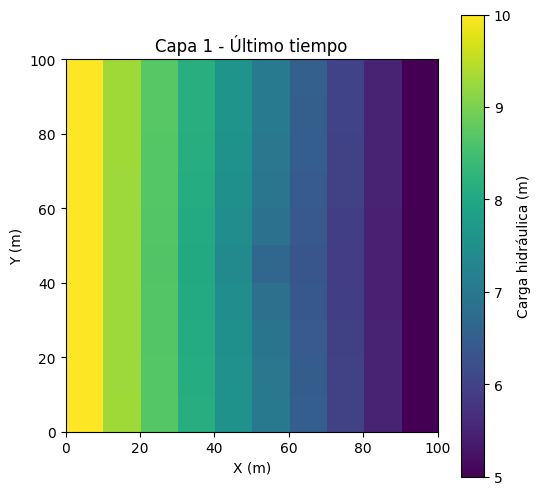

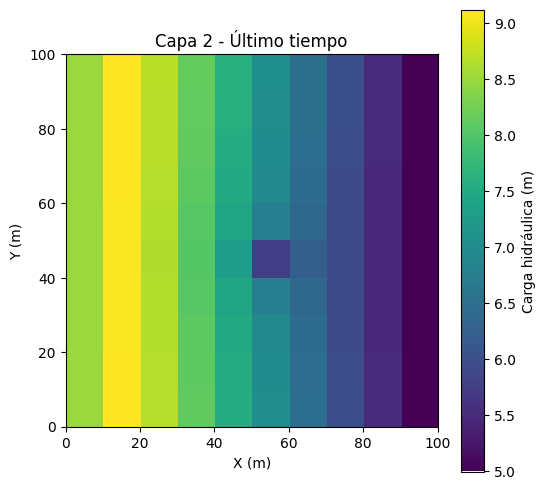

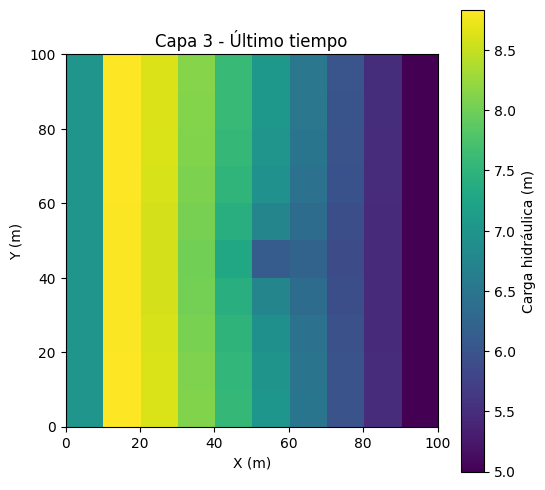

In [7]:
figs = []
for k in range(nlay):
    fig, ax = plt.subplots(figsize=(6, 6))
    arr = headobj.get_data(totim=times[-1])[k, :, :]
    pc = ax.imshow(arr, cmap='viridis', origin='upper', extent=[0, ncol*delc, 0, nrow*delr])
    ax.set_title(f'Capa {k+1} - Último tiempo')
    fig.colorbar(pc, ax=ax, label='Carga hidráulica (m)')
    ax.set_xlabel("X (m)")
    ax.set_ylabel("Y (m)")
    figs.append(fig)
plt.show()

In [8]:
from matplotlib import animation

def animate_capa(k):
    fig, ax = plt.subplots(figsize=(6, 6))
    pc = ax.imshow(headobj.get_data(totim=times[0])[k, :, :],
                   vmin=5, vmax=10, cmap='viridis', origin='upper',
                   extent=[0, ncol*delc, 0, nrow*delr])
    cb = fig.colorbar(pc, ax=ax, label='Carga hidráulica (m)')
    ax.set_title(f'Capa {k+1} - Evolución temporal')

    def update(frame):
        data = headobj.get_data(totim=times[frame])[k, :, :]
        pc.set_data(data)
        ax.set_title(f'Capa {k+1} - Tiempo = {times[frame]:.2f} días')
        return pc,

    ani = animation.FuncAnimation(fig, update, frames=len(times), interval=1000, repeat=False)
    plt.close()
    return ani

# Crear animación para capa 1 (índice 0)
ani = animate_capa(1)
ani.save("capa1_animacion.gif", writer="pillow")
